In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras import utils, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Add, BatchNormalization, Activation

from keras.models import Model
from tensorflow.keras.applications import resnet

from keras.initializers import glorot_uniform

import warnings
warnings.filterwarnings('ignore')

2023-04-24 02:24:42.751739: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 02:25:03.893692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 02:25:32.491833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Loading

In [2]:
dataset = utils.image_dataset_from_directory(
    './figs',
    labels="inferred",
    label_mode="int",
    class_names=['class0', 'class1', 'class2', 'class3'],
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=True,
    seed=109,
    validation_split=0.2,
    subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
trainset, valset = dataset

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Using 1600 files for validation.


2023-04-24 02:26:17.940694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 02:26:24.158468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 02:26:24.158742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Configure Dataset for Performing 

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

trainset = trainset.cache().prefetch(buffer_size=AUTOTUNE)
valset = valset.cache().prefetch(buffer_size=AUTOTUNE)

##normalize the images
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train = trainset.map(lambda x, y: (normalization_layer(x), y))
normalized_val = valset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


2023-04-24 02:27:34.181744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
2023-04-24 02:27:34.182237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
2023-04-24 02:27:37.028282: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipe

0.15294118 1.0


## Load the Untrained Scratch model

In [4]:
resnet50_head = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(258, 347, 3),
    pooling='avg',
    classes=4
)

In [5]:
resnet50_head.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 258, 347, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 264, 353, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 129, 174, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 65, 87, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 65, 87, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 65, 87, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 65, 87, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 33, 44, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 33, 44, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 33, 44, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 33, 44, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 17, 22, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 17, 22, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 17, 22, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 17, 22, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 17, 22, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 9, 11, 2048)  0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 9, 11, 512)   1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 9, 11, 512)  2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 9, 11, 512)  0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [6]:
dense1 = Dense(512, activation='relu')(resnet50_head.output)
outputs = Dense(4, activation='softmax')(dense1)

In [7]:
resnet50 = Model(inputs=resnet50_head.inputs[0], outputs=outputs)
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 258, 347, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 264, 353, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 129, 174, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 65, 87, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 65, 87, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 65, 87, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 65, 87, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 33, 44, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 33, 44, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 33, 44, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 33, 44, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 17, 22, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 17, 22, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 17, 22, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 17, 22, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 17, 22, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 9, 11, 2048)  0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 9, 11, 512)   1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 9, 11, 512)  2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 9, 11, 512)  0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [8]:
# Compiling the model
resnet50.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [81]:
#define early stopping
es = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=0)
##define automatic saving 
save = ModelCheckpoint(
    "./models/resnet50",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
)

In [89]:
##fit 
%time
resnet50.fit(
  normalized_train,
  validation_data=normalized_val,
    epochs=30, callbacks=[es, save]  
)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 10.7 µs
Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1.3040 - accuracy: 0.3884
Epoch 1: val_accuracy did not improve from 0.91875
100/100 [==============================] - 150s 1s/step - loss: 1.3040 - accuracy: 0.3884 - val_loss: 2.4048 - val_accuracy: 0.2600
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.9336 - accuracy: 0.5672
Epoch 2: val_accuracy did not improve from 0.91875
100/100 [==============================] - 118s 1s/step - loss: 0.9336 - accuracy: 0.5672 - val_loss: 8.7954 - val_accuracy: 0.2600
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.6953
Epoch 3: val_accuracy did not improve from 0.91875
100/100 [==============================] - 119s 1s/step - loss: 0.6794 - accuracy: 0.6953 - val_loss: 9.2641 - val_accuracy: 0.2937
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.8709
Epo

INFO:tensorflow:Assets written to: ./models/resnet50/assets


INFO:tensorflow:Assets written to: ./models/resnet50/assets


100/100 [==============================] - 142s 1s/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 0.2359 - val_accuracy: 0.9381
Epoch 10/30
100/100 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9978
Epoch 10: val_accuracy did not improve from 0.93813
100/100 [==============================] - 118s 1s/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 3.9533 - val_accuracy: 0.5869
Epoch 11/30
100/100 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9972
Epoch 11: val_accuracy did not improve from 0.93813
100/100 [==============================] - 119s 1s/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 1.6849 - val_accuracy: 0.7194
Epoch 12/30
100/100 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9961
Epoch 12: val_accuracy did not improve from 0.93813
100/100 [==============================] - 119s 1s/step - loss: 0.0128 - accuracy: 0.9961 - val_loss: 1.6080 - val_accuracy: 0.7031
Epoch 13/30
100/100 [====

INFO:tensorflow:Assets written to: ./models/resnet50/assets


INFO:tensorflow:Assets written to: ./models/resnet50/assets


100/100 [==============================] - 144s 1s/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0625 - val_accuracy: 0.9825
Epoch 17/30
100/100 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9994
Epoch 17: val_accuracy did not improve from 0.98250
100/100 [==============================] - 122s 1s/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 3.4153 - val_accuracy: 0.6056
Epoch 18/30
100/100 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9992
Epoch 18: val_accuracy did not improve from 0.98250
100/100 [==============================] - 120s 1s/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.1478 - val_accuracy: 0.9613
Epoch 19/30
100/100 [==============================] - ETA: 0s - loss: 4.7394e-04 - accuracy: 1.0000
Epoch 19: val_accuracy improved from 0.98250 to 0.98687, saving model to ./models/resnet50


INFO:tensorflow:Assets written to: ./models/resnet50/assets


INFO:tensorflow:Assets written to: ./models/resnet50/assets


100/100 [==============================] - 143s 1s/step - loss: 4.7394e-04 - accuracy: 1.0000 - val_loss: 0.0455 - val_accuracy: 0.9869
Epoch 20/30
100/100 [==============================] - ETA: 0s - loss: 7.7574e-05 - accuracy: 1.0000
Epoch 20: val_accuracy did not improve from 0.98687
100/100 [==============================] - 115s 1s/step - loss: 7.7574e-05 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9862
Epoch 21/30
100/100 [==============================] - ETA: 0s - loss: 5.7908e-05 - accuracy: 1.0000
Epoch 21: val_accuracy did not improve from 0.98687
100/100 [==============================] - 114s 1s/step - loss: 5.7908e-05 - accuracy: 1.0000 - val_loss: 0.0436 - val_accuracy: 0.9869
Epoch 22/30
100/100 [==============================] - ETA: 0s - loss: 4.8970e-05 - accuracy: 1.0000
Epoch 22: val_accuracy did not improve from 0.98687
100/100 [==============================] - 117s 1s/step - loss: 4.8970e-05 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.98

INFO:tensorflow:Assets written to: ./models/resnet50/assets


INFO:tensorflow:Assets written to: ./models/resnet50/assets


100/100 [==============================] - 145s 1s/step - loss: 4.2651e-05 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9875
Epoch 24/30
100/100 [==============================] - ETA: 0s - loss: 3.7777e-05 - accuracy: 1.0000
Epoch 24: val_accuracy did not improve from 0.98750
100/100 [==============================] - 121s 1s/step - loss: 3.7777e-05 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9875
Epoch 25/30
100/100 [==============================] - ETA: 0s - loss: 3.3847e-05 - accuracy: 1.0000
Epoch 25: val_accuracy did not improve from 0.98750
100/100 [==============================] - 120s 1s/step - loss: 3.3847e-05 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9875
Epoch 26/30
100/100 [==============================] - ETA: 0s - loss: 3.0529e-05 - accuracy: 1.0000
Epoch 26: val_accuracy did not improve from 0.98750
100/100 [==============================] - 119s 1s/step - loss: 3.0529e-05 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.98

INFO:tensorflow:Assets written to: ./models/resnet50/assets


INFO:tensorflow:Assets written to: ./models/resnet50/assets


100/100 [==============================] - 158s 2s/step - loss: 2.5144e-05 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9881
Epoch 29/30
100/100 [==============================] - ETA: 0s - loss: 2.2922e-05 - accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 0.98813
100/100 [==============================] - 118s 1s/step - loss: 2.2922e-05 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9881
Epoch 30/30
100/100 [==============================] - ETA: 0s - loss: 2.0964e-05 - accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 0.98813
100/100 [==============================] - 120s 1s/step - loss: 2.0964e-05 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9875


0.9881250262260437


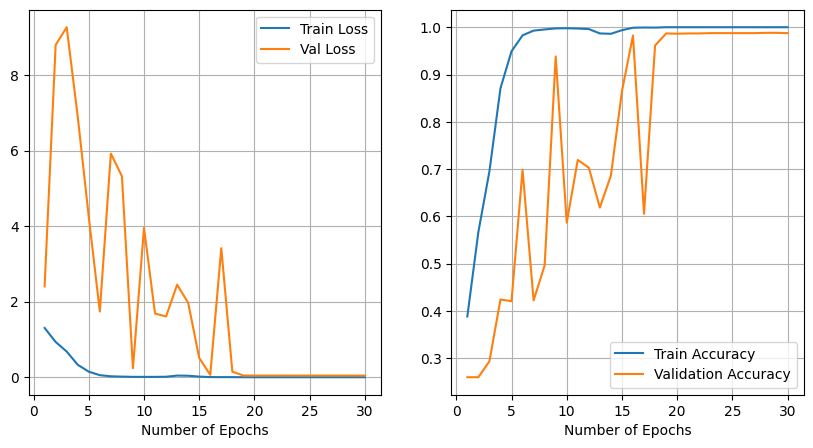

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, len(resnet50.history.history['loss'])+1), resnet50.history.history['loss'], 
           label='Train Loss');
ax[0].plot(range(1, len(resnet50.history.history['val_loss'])+1), 
         resnet50.history.history['val_loss'], label='Val Loss');
ax[0].grid();
ax[0].legend();
ax[0].set_xlabel("Number of Epochs");
ax[1].plot(range(1, len(resnet50.history.history['accuracy'])+1),resnet50.history.history['accuracy'],
          label = 'Train Accuracy')
ax[1].plot(range(1, len(resnet50.history.history['val_accuracy'])+1), resnet50.history.history['val_accuracy'], 
          label = 'Validation Accuracy')
ax[1].grid();
ax[1].legend();
ax[1].set_xlabel("Number of Epochs");
print(max(resnet50.history.history['val_accuracy']))

In [9]:
##reload the model
resnet50 = tf.keras.models.load_model("./models/resnet50")

In [10]:
resnet50.evaluate(normalized_val)

2023-04-24 02:28:31.749629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-04-24 02:28:31.750015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-04-24 02:29:38.412931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-24 02:30:33.608770: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


25/25 [==============================] - 138s 316ms/step - loss: 0.0430 - accuracy: 0.9881


[0.042967673391103745, 0.9881250262260437]

## Test on test images

In [92]:
##load the test image
testset1 = utils.image_dataset_from_directory(
    './test/class1',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

testset2 = utils.image_dataset_from_directory(
    './test/class2',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

testset3 = utils.image_dataset_from_directory(
    './test/class3',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

##normalize the testset
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_testset1 = testset1.map(lambda x: normalization_layer(x))
normalized_testset2 = testset2.map(lambda x: normalization_layer(x))
normalized_testset3 = testset3.map(lambda x: normalization_layer(x))

Found 1800 files belonging to 1 classes.
Found 1414 files belonging to 1 classes.
Found 1800 files belonging to 1 classes.


In [41]:
##predict
prediction1 = np.array([x.argmax() for x in resnet50.predict(normalized_testset1)])
prediction2 = np.array([x.argmax() for x in resnet50.predict(normalized_testset2)]) 
prediction3 = np.array([x.argmax() for x in resnet50.predict(normalized_testset3)])

2023-04-09 14:31:38.647497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-09 14:31:38.652495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 10s 327ms/step


2023-04-09 14:31:49.069722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]
2023-04-09 14:31:49.070045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 7s 327ms/step


2023-04-09 14:31:56.503364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-09 14:31:56.503657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 9s 302ms/step


In [42]:
print(np.unique(prediction1))
print("Number of prediction 0: {}".format((prediction1==0).sum()))
print("Number of prediction 1: {}".format((prediction1==1).sum()))
print("Number of prediction 2: {}".format((prediction1==2).sum()))
print("Number of prediction 3: {}".format((prediction1==3).sum()))

[0 1]
Number of prediction 0: 1795
Number of prediction 1: 5
Number of prediction 2: 0
Number of prediction 3: 0


In [ ]:
1795/1800

In [43]:
print(np.unique(prediction2))
print("Number of prediction 0: {}".format((prediction2==0).sum()))
print("Number of prediction 1: {}".format((prediction2==1).sum()))
print("Number of prediction 2: {}".format((prediction2==2).sum()))
print("Number of prediction 3: {}".format((prediction2==3).sum()))

[0 2 3]
Number of prediction 0: 1166
Number of prediction 1: 0
Number of prediction 2: 242
Number of prediction 3: 6


In [44]:
print(np.unique(prediction3))
print("Number of prediction 0: {}".format((prediction3==0).sum()))
print("Number of prediction 1: {}".format((prediction3==1).sum()))
print("Number of prediction 2: {}".format((prediction3==2).sum()))
print("Number of prediction 3: {}".format((prediction3==3).sum()))

[0 3]
Number of prediction 0: 1692
Number of prediction 1: 0
Number of prediction 2: 0
Number of prediction 3: 108


## Examine the Attention of the model by Saliency Map

In [46]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore

def get_img(batch, index, img_set):
    i = index // batch; j = index % batch
    batch_ = list(iter(img_set.skip(index).take(1)))[0]
    img = batch_[0][j]
    label = batch_[1][j]
    return img, int(label)

##our model returns probability, so need to transform back to logit
def model_modifier(model):
    model.layers[-1].activation=tf.keras.activations.linear

def generate_saliency_map(model, modifier, img, class_index, smooth=0):
    saliency = Saliency(model, model_modifier=modifier, clone=True)
    score = CategoricalScore([class_index])
    saliency_map = saliency(score, img, smooth)
    return saliency_map

def generate_gradcam(model, modifier, img, class_idx):
    gradcam = Gradcam(model, model_modifier=modifier, clone=True)
    score = CategoricalScore([class_idx])
    results = gradcam(score, img)
    return results

##this function plot the saliency maps when the prediction is correct
def plot_saliency_correct(model, modifier, img, class_idx):
    sg_saliency = generate_saliency_map(model, modifier, img, class_idx, smooth=1)[0]
    gc_saliency = generate_gradcam(model, modifier, img, class_idx)[0]
    fig, ax = plt.subplots(1, 2, figsize=(8, 4));
    ax[0].imshow(sg_saliency, cmap='gist_heat', alpha=1);
    ax[0].imshow(img, alpha=0.3);
    ax[0].axis('off');
    ax[0].set_title("Smooth-Grad Saliency Map of class {}".format(class_idx));
    ax[1].imshow(gc_saliency, cmap='gist_heat', alpha=1);
    ax[1].imshow(img, alpha=0.3);
    ax[1].axis('off');
    ax[1].set_title("GradCam Saliency Map of class {}".format(class_idx));
    
##this function plot the saliency maps when the prediction is incorrect
def plot_saliency_wrong(model, modifier, img, real_class, pred_class):
    sg_saliency_real = generate_saliency_map(model, modifier, img, real_class, smooth=1)[0]
    gc_saliency_real = generate_gradcam(model, modifier, img, real_class)[0]
    sg_saliency_pred = generate_saliency_map(model, modifier, img, pred_class, smooth=1)[0]
    gc_saliency_pred = generate_gradcam(model, modifier, img, pred_class)[0]
    fig, ax = plt.subplots(2, 2, figsize=(8, 8));
    ax[0][0].imshow(sg_saliency_real, cmap='gist_heat', alpha=1);
    ax[0][0].imshow(img, alpha=0.2);
    ax[0][0].axis('off');
    ax[0][0].set_title("Smooth-Grad Saliency Map of class {}".format(real_class));
    ax[0][1].imshow(gc_saliency_real, cmap='gist_heat', alpha=1);
    ax[0][1].imshow(img, alpha=0.2);
    ax[0][1].axis('off');
    ax[0][1].set_title("GradCam Saliency Map of class {}".format(real_class));
    ax[1][0].imshow(sg_saliency_pred, cmap='gist_heat', alpha=1);
    ax[1][0].imshow(img, alpha=0.2);
    ax[1][0].axis('off');
    ax[1][0].set_title("Smooth-Grad Saliency Map of class {}".format(pred_class));
    ax[1][1].imshow(gc_saliency_pred, cmap='gist_heat', alpha=1);
    ax[1][1].imshow(img, alpha=0.2);
    ax[1][1].axis('off');
    ax[1][1].set_title("GradCam Saliency Map of class {}".format(pred_class));

### Examine How the Model sees the images in the train and validation Images first

In [47]:
one_batch_val = list(iter(normalized_val.skip(0).take(1)))
index0 = np.where(one_batch_val[0][1].numpy()==0)[0]
index1 = np.where(one_batch_val[0][1].numpy()==1)[0]
index2 = np.where(one_batch_val[0][1].numpy()==2)[0]
index3 = np.where(one_batch_val[0][1].numpy()==3)[0]

2023-04-09 14:34:16.146430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1600]
	 [[{{node Placeholder/_0}}]]
2023-04-09 14:34:16.146885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]


In [48]:
val_img0 = one_batch_val[0][0][index0[0]]
val_img1 = one_batch_val[0][0][index1[0]]
val_img2 = one_batch_val[0][0][index2[0]]
val_img3 = one_batch_val[0][0][index3[0]]
single_pred0 = resnet50.predict(np.expand_dims(val_img0, axis=0)).argmax()
single_pred1 = resnet50.predict(np.expand_dims(val_img1, axis=0)).argmax()
single_pred2 = resnet50.predict(np.expand_dims(val_img2, axis=0)).argmax()
single_pred3 = resnet50.predict(np.expand_dims(val_img3, axis=0)).argmax()

1/1 [==============================] - 0s 28ms/step


Model correctly predicted 0


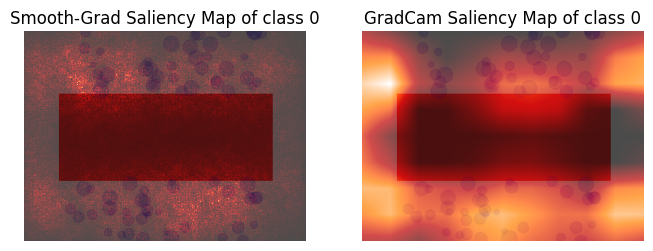

In [49]:
if single_pred0 == 0:
    print("Model correctly predicted 0")
    plot_saliency_correct(resnet50, model_modifier, val_img0, 0)
else:
    print("Model misclassified as: {}, but shoud be 0".format(single_pred0))
    plot_saliency_wrong(resnet50, model_modifier, val_img0, 0, single_pred0)

Model correctly predicted 1


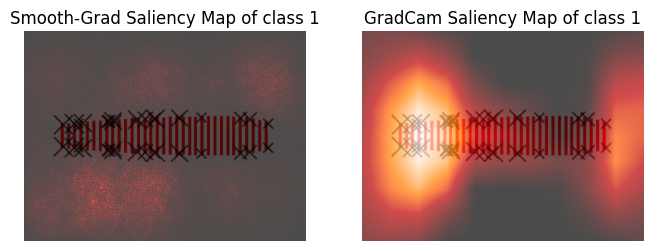

In [50]:
if single_pred1 == 1:
    print("Model correctly predicted 1")
    plot_saliency_correct(resnet50, model_modifier, val_img1, 1)
else:
    print("Model misclassified as: {}, but shoud be 1".format(single_pred1))
    plot_saliency_wrong(resnet50, model_modifier, val_img1, 1, single_pred1)

Model correctly predicted 2


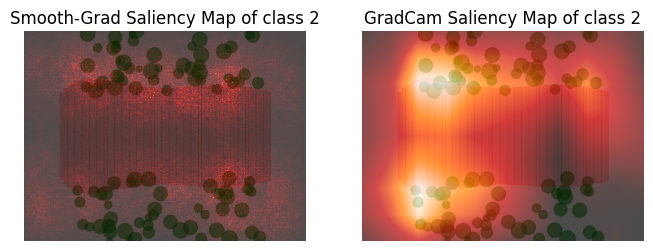

In [51]:
if single_pred2 == 2:
    print("Model correctly predicted 2")
    plot_saliency_correct(resnet50, model_modifier, val_img2, 2)
else:
    print("Model misclassified as: {}, but shoud be 2".format(single_pred2))
    plot_saliency_wrong(resnet50, model_modifier, val_img2, 2, single_pred2)

Model correctly predicted 3


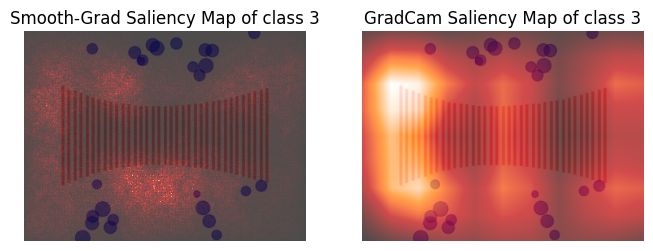

In [52]:
if single_pred3 == 3:
    print("Model correctly predicted 3")
    plot_saliency_correct(resnet50, model_modifier, val_img3, 3)
else:
    print("Model misclassified as: {}, but shoud be 3".format(single_pred3))
    plot_saliency_wrong(resnet50, model_modifier, val_img3, 3, single_pred3)

### Examine the test image
#### Test Image, class 1

2023-04-09 14:50:22.217812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-09 14:50:22.218242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


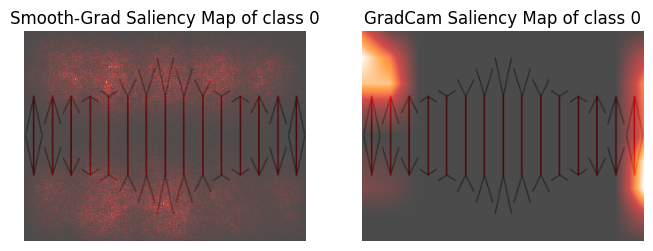

In [53]:
##correct classification example
index = np.where(prediction1==0)[0][0]
batch_size = 64
img = list(iter(normalized_testset1.skip(index//batch_size).take(1)))[0][index%batch_size]
plot_saliency_correct(resnet50, model_modifier, img, 0)

2023-04-09 14:56:54.099276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-09 14:56:54.099720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 29ms/step


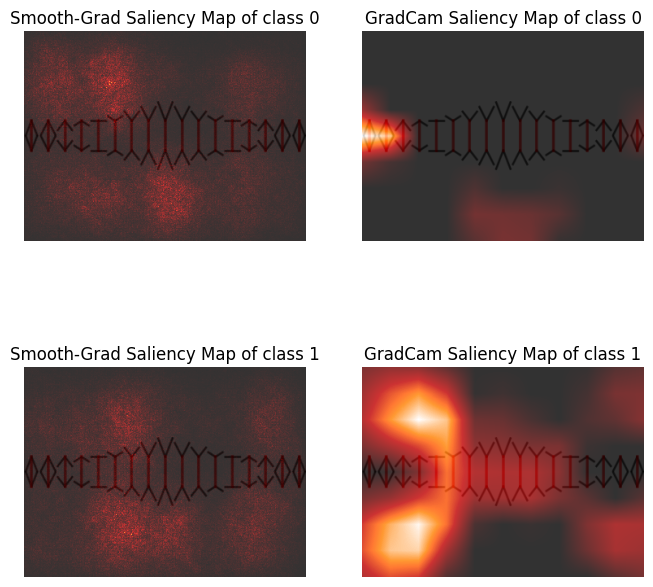

In [57]:
##misclassified as 1
index = np.where(prediction1==1)[0][2]
batch_size = 64
img = list(iter(normalized_testset1.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet50.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet50, model_modifier, img, 0, pred)

### Test Image, class 2

2023-04-09 14:57:58.837229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]
2023-04-09 14:57:58.837720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]


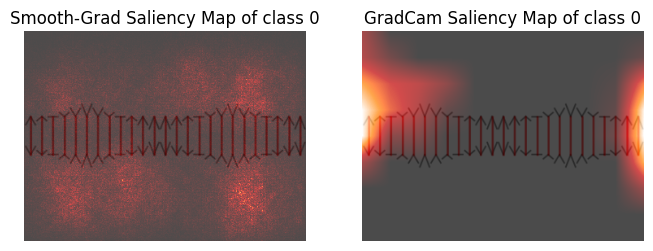

In [60]:
##correct classification example
index = np.where(prediction2==0)[0][200]
batch_size = 64
img = list(iter(normalized_testset2.skip(index//batch_size).take(1)))[0][index%batch_size]
plot_saliency_correct(resnet50, model_modifier, img, 0)

2023-04-09 14:58:14.723139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]
2023-04-09 14:58:14.723570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 30ms/step


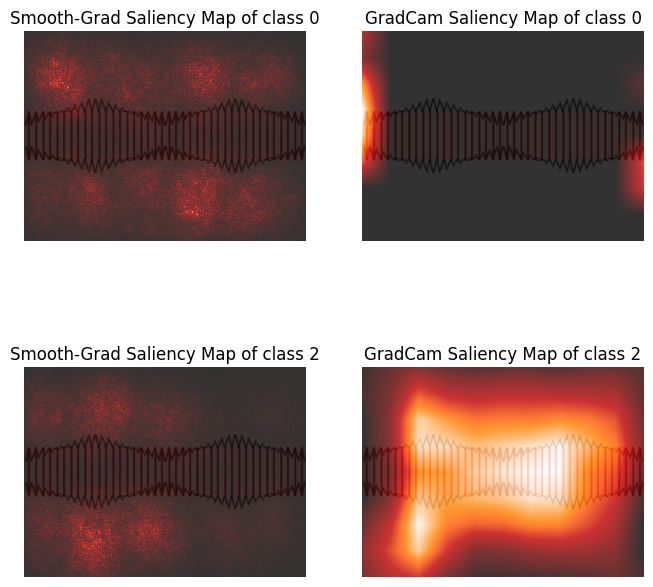

In [61]:
##misclassified as 2
index = np.where(prediction2==2)[0][-1]
batch_size = 64
img = list(iter(normalized_testset2.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet50.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet50, model_modifier, img, 0, pred)

2023-04-09 14:58:33.875722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]
2023-04-09 14:58:33.876123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 29ms/step


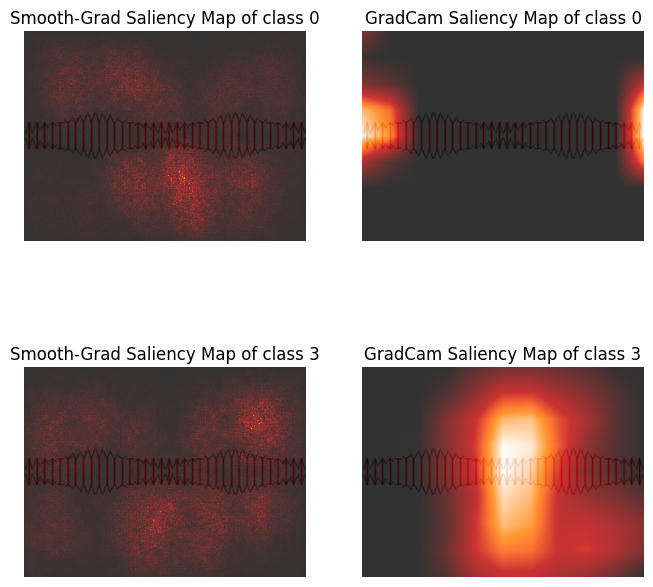

In [62]:
##misclassified as 3
index = np.where(prediction2==3)[0][-1]
batch_size = 64
img = list(iter(normalized_testset2.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet50.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet50, model_modifier, img, 0, pred)

### Test Image, class 3

2023-04-09 15:14:22.453125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-09 15:14:22.453584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


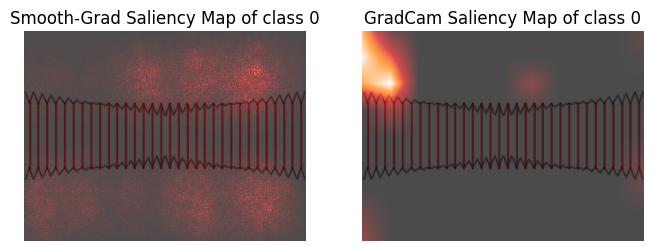

In [64]:
##correct classification example
index = np.where(prediction3==0)[0][1000]
batch_size = 64
img = list(iter(normalized_testset3.skip(index//batch_size).take(1)))[0][index%batch_size]
plot_saliency_correct(resnet50, model_modifier, img, 0)

2023-04-09 15:15:28.793115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-09 15:15:28.793620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 29ms/step


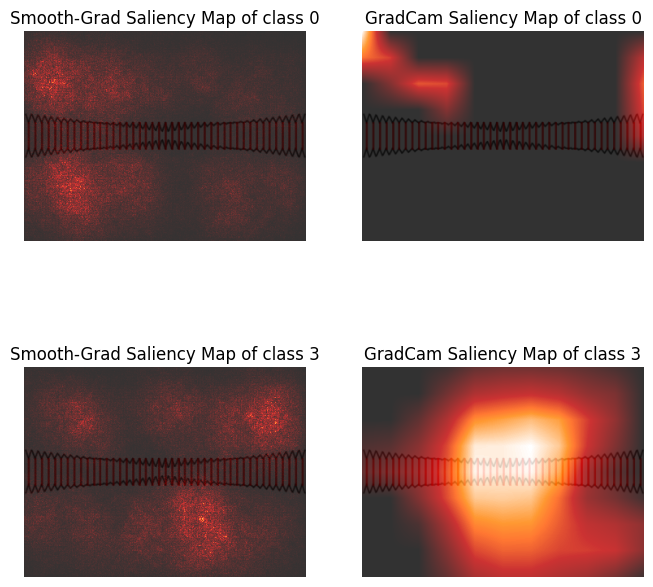

In [65]:
##misclassified as 3
index = np.where(prediction3==3)[0][-1]
batch_size = 64
img = list(iter(normalized_testset3.skip(index//batch_size).take(1)))[0][index%batch_size]
pred = resnet50.predict(np.expand_dims(img, axis=0)).argmax()
plot_saliency_wrong(resnet50, model_modifier, img, 0, pred)

## Load Check Images

In [11]:
##load the check image
checkset1 = utils.image_dataset_from_directory(
    './test/check1',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

checkset2 = utils.image_dataset_from_directory(
    './test/check2',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

checkset3 = utils.image_dataset_from_directory(
    './test/check3',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

##normalize the testset
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_checkset1 = checkset1.map(lambda x: normalization_layer(x))
normalized_checkset2 = checkset2.map(lambda x: normalization_layer(x))
normalized_checkset3 = checkset3.map(lambda x: normalization_layer(x))

Found 1800 files belonging to 1 classes.
Found 1796 files belonging to 1 classes.
Found 1800 files belonging to 1 classes.


In [12]:
prediction_check1 = np.array([x.argmax() for x in resnet50.predict(normalized_checkset1)])
prediction_check2 = np.array([x.argmax() for x in resnet50.predict(normalized_checkset2)]) 
prediction_check3 = np.array([x.argmax() for x in resnet50.predict(normalized_checkset3)])

2023-04-24 02:32:19.681767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-24 02:32:19.682074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 10s 338ms/step


2023-04-24 02:32:30.427811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1796]
	 [[{{node Placeholder/_0}}]]
2023-04-24 02:32:30.428076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1796]
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 9s 326ms/step


2023-04-24 02:32:39.798203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-24 02:32:39.798472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 9s 308ms/step


In [13]:
print(np.unique(prediction_check1))
print("Number of prediction 0: {}".format((prediction_check1==0).sum()))
print("Number of prediction 1: {}".format((prediction_check1==1).sum()))
print("Number of prediction 2: {}".format((prediction_check1==2).sum()))
print("Number of prediction 3: {}".format((prediction_check1==3).sum()))

[0 2]
Number of prediction 0: 1799
Number of prediction 1: 0
Number of prediction 2: 1
Number of prediction 3: 0


In [14]:
print(np.unique(prediction_check2))
print("Number of prediction 0: {}".format((prediction_check2==0).sum()))
print("Number of prediction 1: {}".format((prediction_check2==1).sum()))
print("Number of prediction 2: {}".format((prediction_check2==2).sum()))
print("Number of prediction 3: {}".format((prediction_check2==3).sum()))

[0]
Number of prediction 0: 1796
Number of prediction 1: 0
Number of prediction 2: 0
Number of prediction 3: 0


In [15]:
print(np.unique(prediction_check3))
print("Number of prediction 0: {}".format((prediction_check3==0).sum()))
print("Number of prediction 1: {}".format((prediction_check3==1).sum()))
print("Number of prediction 2: {}".format((prediction_check3==2).sum()))
print("Number of prediction 3: {}".format((prediction_check3==3).sum()))

[0 3]
Number of prediction 0: 1799
Number of prediction 1: 0
Number of prediction 2: 0
Number of prediction 3: 1
